# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from src.sam_segmentation.yolo import load_yolov8_detector, yolov8_detect, draw_bounding_boxes
from src.sam_segmentation.sam import load_sam_predictor, sam_segmentation
from src.sam_segmentation.utils import unite_masks, masks_narrowing

# Utils functions


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


# YOLOv8 trained on custom bubbles dataset

In [3]:
custom_yolo_checkpoint_path = r"C:\Internship\ITMO_ML\CTCI\checkpoints\yolov8\yolov8s_on_mid_bubbles_69\run2_80_epochs\weights\best.pt"
detector = load_yolov8_detector(custom_yolo_checkpoint_path)

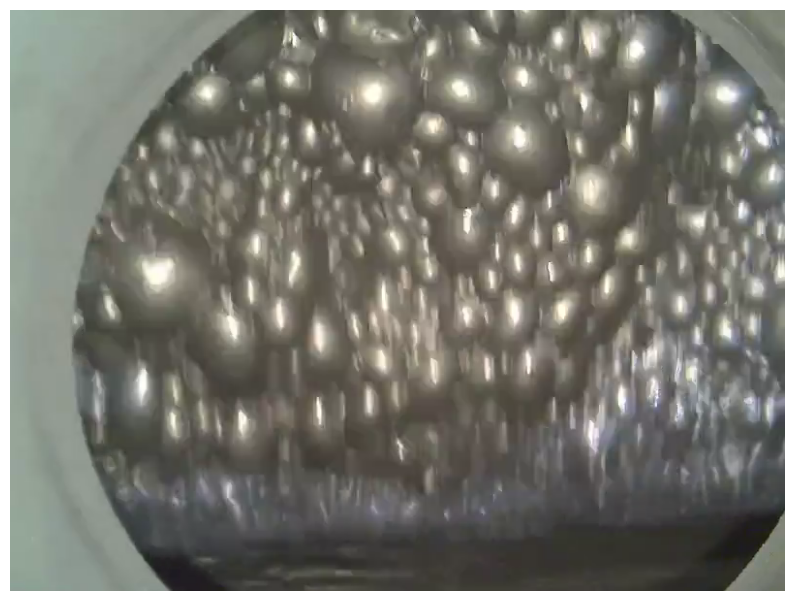

In [4]:
image = cv2.imread(r'C:\Internship\ITMO_ML\CTCI\data\frame-4.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
boxes = yolov8_detect(image=image, detector=detector, return_objects=False)

0: 608x800 78 bubbles, 166.6ms
Speed: 4.0ms preprocess, 166.6ms inference, 68.8ms postprocess per image at shape (1, 3, 608, 800)


In [6]:
print(boxes)

[[300.05517578125, 28.86328125, 429.8760986328125, 160.09266662597656], [482.9122619628906, 91.38982391357422, 580.9764404296875, 195.8427734375], [422.761962890625, 51.30973434448242, 516.6762084960938, 127.85499572753906], [177.28460693359375, 286.10595703125, 270.82244873046875, 405.88641357421875], [502.734375, 186.46263122558594, 543.4212646484375, 241.46534729003906], [290.52960205078125, 385.8536682128906, 349.41400146484375, 479.2345275878906], [430.5584411621094, 198.02157592773438, 502.2169494628906, 273.9316711425781], [618.9771728515625, 0.21929168701171875, 697.7369384765625, 88.40968322753906], [158.45437622070312, 59.817745208740234, 245.78781127929688, 138.28274536132812], [295.1064453125, 298.2496337890625, 356.293701171875, 390.6746826171875], [94.919189453125, 218.35862731933594, 215.80361938476562, 344.548828125], [650.8250732421875, 62.08686828613281, 709.6956787109375, 161.23797607421875], [566.019287109375, 154.1416778564453, 657.94921875, 239.50355529785156], [5

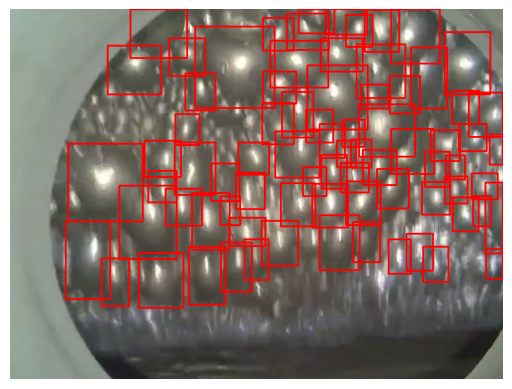

In [7]:
image_example = image.copy()

draw_bounding_boxes(image=image_example, boxes=boxes)

# SAM Checkpoint

In [8]:
sam_checkpoint = r"C:\Internship\ITMO_ML\CTCI\checkpoints\sam_checkpoints\sam_vit_h_4b8939.pth"
model_type = "vit_h"
device="cuda"

predictor = load_sam_predictor(checkpoint_path=sam_checkpoint, model_type=model_type, device=device)

Predictor's device is cuda:0


# Segmentation by bounding box prompt

In [9]:
from segment_anything.utils.transforms import ResizeLongestSide
transform = ResizeLongestSide(target_length=1024)


In [10]:
predictor.set_image(image=image)

In [11]:
points = [np.array([[(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]]) for box in boxes]

In [12]:
points = np.array(points)

In [13]:
print(predictor.original_size)

(600, 800)


In [15]:
boxes = transform.apply_boxes(np.array(boxes), (predictor.original_size[0], predictor.original_size[1]))
points = transform.apply_coords(np.array(points), (predictor.original_size[0], predictor.original_size[1]))

In [16]:
boxes_tensor = torch.Tensor(boxes)
points_tensor = torch.Tensor(points)

labels_tensor = torch.ones((points.shape[0], points.shape[1]))

In [17]:
print(boxes_tensor.shape)
print(points_tensor.shape)
print(labels_tensor.shape)

torch.Size([78, 4])
torch.Size([78, 1, 2])
torch.Size([78, 1])


In [18]:
masks_list, _, _ = predictor.predict_torch(
    boxes=boxes_tensor,
    point_coords=points_tensor,
    point_labels=labels_tensor,
    multimask_output=False
)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [ ]:
print(masks_list.shape)

In [19]:
masks_list = masks_list.numpy()
plt.figure()
plt.imshow(image)

for i in range(len(masks_list)):
    masks = masks_list[i]
    show_mask(masks[0], plt.gca())

plt.axis('off')
plt.show()

NameError: name 'masks_list' is not defined

Masks unification:

In [ ]:
masks_united = []
for masks in masks_list:
    masks_united.append(unite_masks(masks))


In [ ]:
mask_united = unite_masks(masks_united)

In [ ]:
plt.imshow(mask_united, cmap="gray")
plt.axis('off')

Masks narrowing:

In [ ]:
narrowing = 0.25

In [ ]:
masks_narrowed = masks_narrowing(masks_united, narrowing=narrowing)

In [ ]:
mask_united_narrowed = unite_masks(masks_narrowed)

Result:

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(36, 12)

ax[0].imshow(mask_united, cmap="gray")
ax[0].set_title("Masks base")
ax[1].imshow(mask_united_narrowed, cmap="gray")
ax[1].set_title(f"Maks narrowed, narrowing={narrowing}")

ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [ ]:
plt.imshow(mask_united_narrowed, cmap="gray")
plt.axis('off')

# Segmentation by bounding box and point prompt


In [ ]:
masks_list = sam_segmentation(image=image, predictor=predictor, boxes=boxes, prompt_point=True)

plt.figure()
plt.imshow(image)

for i in range(len(masks_list)):
    masks = masks_list[i]
    show_mask(masks[0], plt.gca())

plt.axis('off')
plt.show()